In [ ]:
# STEP 1: Environment sanity check

import sys
import platform

print("Python version:", sys.version)
print("Platform:", platform.platform())

# Basic sanity imports
import numpy as np
import pandas as pd

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
NumPy version: 2.0.2
Pandas version: 2.2.2


In [ ]:
# STEP 2 (NEW): Basic Hindi text ingestion & sanity check

hindi_text = """
लड़की स्कूल जा रही थी।
लड़के ने किताब पढ़ी।
मैंने खाना खाया और सो गया।
भारत एक विशाल देश है।
"""

# Basic sentence split using Hindi danda
sentences = [s.strip() for s in hindi_text.split("।") if s.strip()]

print("Total sentences:", len(sentences))
for i, s in enumerate(sentences, 1):
    print(f"{i}. {s}")


Total sentences: 4
1. लड़की स्कूल जा रही थी
2. लड़के ने किताब पढ़ी
3. मैंने खाना खाया और सो गया
4. भारत एक विशाल देश है


In [ ]:
# STEP 3: Word-level tokenization (baseline)

tokenized_sentences = [s.split() for s in sentences]

print("Tokenized sentences:")
for s in tokenized_sentences:
    print(s)


Tokenized sentences:
['लड़की', 'स्कूल', 'जा', 'रही', 'थी']
['लड़के', 'ने', 'किताब', 'पढ़ी']
['मैंने', 'खाना', 'खाया', 'और', 'सो', 'गया']
['भारत', 'एक', 'विशाल', 'देश', 'है']


In [ ]:
# STEP 4 (FINAL FIX): Load controlled subset of Hindi Wikipedia

from datasets import load_dataset

wiki = load_dataset(
    "wikimedia/wikipedia",
    "20231101.hi",
    split="train[:10000]"  # absolute slicing
)

print("Total documents loaded:", len(wiki))
print("\nSample document:\n")
print(wiki[0]["text"][:500])


Total documents loaded: 10000

Sample document:

हम होंगे कामयाब ( का गिरिजा कुमार माथुर द्वारा किया गया हिंदी भावानुवाद) एक प्रतिरोध गीत है। यह गीत बीसवीं सदी में नागरिक अधिकार आंदोलन का प्रधान स्वर बना। इस गीत को आमतौर पर "I'll Overcome Some Day" ("आई विल ओवरकम सम डे") से काव्यावतरित माना जाता है, जो चार्ल्स अल्बर्ट टिंडले द्वारा गाया गया था और जिसे 1900 में पहली बार प्रकाशित किया गया था।

सन्दर्भ
Hum Honge Kamyab Lyrics 
नागरिक अधिकार आंदोलन
देशभक्ति के गीत
आधार


In [ ]:
# STEP 5: Sentence extraction & basic normalization

import unicodedata
import re

def clean_and_split(text):
    # Unicode normalization
    text = unicodedata.normalize("NFC", text)

    # Remove reference/heading lines
    lines = text.split("\n")
    lines = [
        line.strip() for line in lines
        if line.strip() and not re.match(r"^(सन्दर्भ|सन्दर्भ:|References)$", line)
    ]

    text = " ".join(lines)

    # Split sentences using Hindi danda
    sentences = [s.strip() for s in text.split("।") if len(s.strip()) > 5]
    return sentences

# Apply to first 5 documents only (sanity check)
all_sentences = []
for i in range(5):
    all_sentences.extend(clean_and_split(wiki[i]["text"]))

print("Total extracted sentences (from 5 docs):", len(all_sentences))
print("\nSample sentences:\n")
for s in all_sentences[:10]:
    print("-", s)


Total extracted sentences (from 5 docs): 479

Sample sentences:

- हम होंगे कामयाब ( का गिरिजा कुमार माथुर द्वारा किया गया हिंदी भावानुवाद) एक प्रतिरोध गीत है
- यह गीत बीसवीं सदी में नागरिक अधिकार आंदोलन का प्रधान स्वर बना
- इस गीत को आमतौर पर "I'll Overcome Some Day" ("आई विल ओवरकम सम डे") से काव्यावतरित माना जाता है, जो चार्ल्स अल्बर्ट टिंडले द्वारा गाया गया था और जिसे 1900 में पहली बार प्रकाशित किया गया था
- Hum Honge Kamyab Lyrics नागरिक अधिकार आंदोलन देशभक्ति के गीत आधार
- दैनिक पूजा विधि हिन्दू धर्म की कई उपासना पद्धतियों में से एक है
- ये एक दैनिक कर्म है
- विभिन्न देवताओं को प्रसन्न करने के लिये कई मन्त्र बताये गये हैं, जो लगभग सभी पुराणों से हैं
- वैदिक मन्त्र यज्ञ और हवन के लिये होते हैं
- पूजा की रीति इस तरह है : पहले कोई भी देवता चुनें, जिसकी पूजा करनी है
- फ़िर विधिवत निम्नलिखित मन्त्रों (सभी संस्कृत में हैं) के साथ उसकी पूजा करें


In [ ]:
# STEP 6 (FIXED): Final corpus build + dataset statistics (self-contained)

import unicodedata
import re
from collections import Counter

# ---------- Helpers (redefined for reproducibility) ----------

def clean_and_split(text):
    text = unicodedata.normalize("NFC", text)
    lines = text.split("\n")
    lines = [
        line.strip() for line in lines
        if line.strip() and not re.match(r"^(सन्दर्भ|सन्दर्भ:|References)$", line)
    ]
    text = " ".join(lines)
    sentences = [s.strip() for s in text.split("।") if len(s.strip()) > 5]
    return sentences

def is_hindi_heavy(sentence, threshold=0.6):
    dev = sum(1 for c in sentence if '\u0900' <= c <= '\u097F')
    alpha = sum(1 for c in sentence if c.isalpha())
    if alpha == 0:
        return False
    return (dev / alpha) >= threshold

def devanagari_ratio(text):
    dev = sum(1 for c in text if '\u0900' <= c <= '\u097F')
    alpha = sum(1 for c in text if c.isalpha())
    return dev / alpha if alpha > 0 else 0

# ---------- Build corpus ----------

all_sentences = []
for doc in wiki:
    all_sentences.extend(clean_and_split(doc["text"]))

final_sentences = [s for s in all_sentences if is_hindi_heavy(s)]
tokenized_corpus = [s.split() for s in final_sentences if len(s.split()) >= 3]

# ---------- Statistics ----------

num_docs = len(wiki)
num_sentences_before = len(all_sentences)
num_sentences_after = len(tokenized_corpus)

sentence_lengths = [len(s) for s in tokenized_corpus]
avg_sentence_len = sum(sentence_lengths) / len(sentence_lengths)

vocab = Counter(word for sent in tokenized_corpus for word in sent)
vocab_size = len(vocab)

avg_script_purity = sum(
    devanagari_ratio(" ".join(s)) for s in tokenized_corpus
) / len(tokenized_corpus)

# ---------- PRINT (PAPER-READY) ----------

print("DATASET STATISTICS")
print("-" * 45)
print(f"Documents used            : {num_docs}")
print(f"Sentences (raw)           : {num_sentences_before}")
print(f"Sentences (final)         : {num_sentences_after}")
print(f"Average sentence length   : {avg_sentence_len:.2f} tokens")
print(f"Vocabulary size           : {vocab_size}")
print(f"Average script purity     : {avg_script_purity:.2f}")
print(f"Noise filtered (%)        : {100 * (1 - num_sentences_after / num_sentences_before):.2f}%")


DATASET STATISTICS
---------------------------------------------
Documents used            : 10000
Sentences (raw)           : 226559
Sentences (final)         : 225271
Average sentence length   : 20.53 tokens
Vocabulary size           : 299156
Average script purity     : 1.64
Noise filtered (%)        : 0.57%


In [ ]:
# FINAL FIX: Proper script purity metric (bounded in [0,1])

def devanagari_ratio_correct(text):
    dev = sum(1 for c in text if '\u0900' <= c <= '\u097F')
    visible = sum(1 for c in text if not c.isspace())
    return dev / visible if visible > 0 else 0

avg_script_purity_correct = sum(
    devanagari_ratio_correct(" ".join(s)) for s in tokenized_corpus
) / len(tokenized_corpus)

print(f"Final average script purity : {avg_script_purity_correct:.3f}")


Final average script purity : 0.963


In [ ]:
# STEP 7: Train Skip-gram Word2Vec baseline

!pip install -q gensim

from gensim.models import Word2Vec
import time

start_time = time.time()

w2v_baseline = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=300,
    window=5,
    min_count=5,
    sg=1,              # Skip-gram
    negative=10,
    workers=4,
    epochs=5
)

train_time = time.time() - start_time

print("BASELINE MODEL TRAINED")
print("-" * 35)
print("Vocabulary size :", len(w2v_baseline.wv))
print("Embedding dim   :", w2v_baseline.vector_size)
print("Training time   : {:.2f} seconds".format(train_time))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 37.6 MB/s eta 0:00:00
BASELINE MODEL TRAINED
-----------------------------------
Vocabulary size : 41648
Embedding dim   : 300
Training time   : 371.64 seconds


In [ ]:
# STEP 7 (LIGHT BASELINE): Faster Skip-gram training

from gensim.models import Word2Vec
import time

start_time = time.time()

w2v_baseline = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,    # reduced
    window=5,
    min_count=5,
    sg=1,               # Skip-gram
    negative=5,         # reduced
    workers=4,
    epochs=3             # reduced
)

train_time = time.time() - start_time

print("BASELINE MODEL TRAINED (LIGHT)")
print("-" * 40)
print("Vocabulary size :", len(w2v_baseline.wv))
print("Embedding dim   :", w2v_baseline.vector_size)
print("Training time   : {:.2f} seconds".format(train_time))


BASELINE MODEL TRAINED (LIGHT)
----------------------------------------
Vocabulary size : 41648
Embedding dim   : 100
Training time   : 83.07 seconds


In [ ]:
# STEP 8.1: Sentence embedding using averaged word vectors

import numpy as np

def sentence_embedding(sentence, model):
    vectors = []
    for word in sentence.split():
        if word in model.wv:
            vectors.append(model.wv[word])
    if not vectors:
        return None
    return np.mean(vectors, axis=0)


In [ ]:
# STEP 8.2: Manual sentence similarity checks

from numpy.linalg import norm

def cosine_sim(v1, v2):
    return np.dot(v1, v2) / (norm(v1) * norm(v2))

pairs = [
    ("लड़की स्कूल जा रही थी", "लड़का विद्यालय जा रहा था"),   # similar
    ("भारत एक विशाल देश है", "भारत एशिया में स्थित है"),    # similar
    ("लड़की स्कूल जा रही थी", "मौसम आज बहुत अच्छा है"),     # dissimilar
]

for s1, s2 in pairs:
    v1 = sentence_embedding(s1, w2v_baseline)
    v2 = sentence_embedding(s2, w2v_baseline)
    if v1 is None or v2 is None:
        print("Skipping pair (OOV issue)")
        continue
    sim = cosine_sim(v1, v2)
    print(f"Similarity('{s1}' , '{s2}') = {sim:.3f}")


Similarity('लड़की स्कूल जा रही थी' , 'लड़का विद्यालय जा रहा था') = 0.815
Similarity('भारत एक विशाल देश है' , 'भारत एशिया में स्थित है') = 0.867
Similarity('लड़की स्कूल जा रही थी' , 'मौसम आज बहुत अच्छा है') = 0.608


In [ ]:
# STEP 9.1: Morphological similarity baseline (Skip-gram)

morph_sets = {
    "गया": ["गई", "गए"],
    "लड़की": ["लड़कियाँ"],
    "करता": ["करती", "करते"],
    "खाया": ["खाई", "खाए"]
}

for root, forms in morph_sets.items():
    if root not in w2v_baseline.wv:
        print(f"{root} not in vocab")
        continue

    for f in forms:
        if f not in w2v_baseline.wv:
            print(f"  {f} not in vocab")
            continue

        sim = w2v_baseline.wv.similarity(root, f)
        print(f"Similarity('{root}' , '{f}') = {sim:.3f}")


Similarity('गया' , 'गई') = 0.498
Similarity('गया' , 'गए') = 0.474
Similarity('लड़की' , 'लड़कियाँ') = 0.689
Similarity('करता' , 'करती') = 0.830
Similarity('करता' , 'करते') = 0.675
Similarity('खाया' , 'खाई') = 0.640
Similarity('खाया' , 'खाए') = 0.823


In [ ]:
# STEP 10.1: Simple rule-based Hindi morpheme segmentation

# Common Hindi suffixes (not exhaustive, but linguistically meaningful)
HINDI_SUFFIXES = [
    "ाएँ", "ाए", "ियाँ", "ियों",
    "ाता", "ाती", "ाते",
    "ाया", "ायी", "ाये",
    "ती", "ता", "ते",
    "ी", "ा", "े", "ं"
]

def segment_word(word):
    for suf in sorted(HINDI_SUFFIXES, key=len, reverse=True):
        if word.endswith(suf) and len(word) > len(suf) + 1:
            root = word[:-len(suf)]
            return [root, suf]
    return [word]  # no segmentation


In [ ]:
# RE-RUN STEP 10.2: Train morpheme embeddings (required)

from gensim.models import Word2Vec
import time

# Safety check
assert 'tokenized_corpus' in globals(), "tokenized_corpus not found"
assert 'segment_word' in globals(), "segment_word() not found"

# Build morpheme corpus
morpheme_corpus = []

for sentence in tokenized_corpus:
    morpheme_sentence = []
    for word in sentence:
        morpheme_sentence.extend(segment_word(word))
    if len(morpheme_sentence) >= 3:
        morpheme_corpus.append(morpheme_sentence)

print("Total morpheme sentences:", len(morpheme_corpus))
print("Sample morpheme sentence:", morpheme_corpus[0])

# Train morpheme embeddings
start_time = time.time()

morph_w2v = Word2Vec(
    sentences=morpheme_corpus,
    vector_size=100,
    window=5,
    min_count=5,
    sg=1,
    negative=5,
    workers=4,
    epochs=3
)

train_time = time.time() - start_time

print("\nMORPHEME MODEL TRAINED")
print("-" * 40)
print("Morpheme vocab size :", len(morph_w2v.wv))
print("Embedding dim       :", morph_w2v.vector_size)
print("Training time       : {:.2f} seconds".format(train_time))


Total morpheme sentences: 225271
Sample morpheme sentence: ['हम', 'होंग', 'े', 'कामयाब', '(', 'का', 'गिरिज', 'ा', 'कुमार', 'माथुर', 'द्वार', 'ा', 'किय', 'ा', 'गय', 'ा', 'हिंद', 'ी', 'भावानुवाद)', 'एक', 'प्रतिरोध', 'गीत', 'है']

MORPHEME MODEL TRAINED
----------------------------------------
Morpheme vocab size : 38031
Embedding dim       : 100
Training time       : 85.77 seconds


In [ ]:
# STEP 10.3: Compose morphology-aware word embeddings (FINAL)

import numpy as np

def morphology_aware_vector(word, word_model, morph_model):
    if word not in word_model.wv:
        return None

    base_vec = word_model.wv[word]
    morphs = segment_word(word)

    morph_vecs = [morph_model.wv[m] for m in morphs if m in morph_model.wv]

    if morph_vecs:
        return base_vec + np.mean(morph_vecs, axis=0)
    else:
        return base_vec


# ---- Sanity check ----
test_words = ["गया", "गई", "गए", "लड़की", "लड़कियाँ"]

for w in test_words:
    vec = morphology_aware_vector(w, w2v_baseline, morph_w2v)
    print(f"{w:10s} -> {'OK' if vec is not None else 'OOV'}, dim={None if vec is None else vec.shape}")


गया        -> OK, dim=(100,)
गई         -> OK, dim=(100,)
गए         -> OK, dim=(100,)
लड़की      -> OK, dim=(100,)
लड़कियाँ   -> OK, dim=(100,)


In [ ]:
# STEP 11.1: Morphological consistency (baseline vs morph-aware)

def cosine_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

morph_sets = {
    "गया": ["गई", "गए"],
    "लड़की": ["लड़कियाँ"],
    "करता": ["करती", "करते"],
    "खाया": ["खाई", "खाए"]
}

print("MORPHOLOGICAL CONSISTENCY COMPARISON")
print("-" * 50)

for root, forms in morph_sets.items():
    for f in forms:
        if root not in w2v_baseline.wv or f not in w2v_baseline.wv:
            continue

        # baseline
        b_sim = w2v_baseline.wv.similarity(root, f)

        # morphology-aware
        v1 = morphology_aware_vector(root, w2v_baseline, morph_w2v)
        v2 = morphology_aware_vector(f, w2v_baseline, morph_w2v)
        m_sim = cosine_sim(v1, v2)

        print(f"{root}–{f} | baseline={b_sim:.3f} | morph-aware={m_sim:.3f}")


MORPHOLOGICAL CONSISTENCY COMPARISON
--------------------------------------------------
गया–गई | baseline=0.498 | morph-aware=0.569
गया–गए | baseline=0.474 | morph-aware=0.564
लड़की–लड़कियाँ | baseline=0.689 | morph-aware=0.712
करता–करती | baseline=0.830 | morph-aware=0.818
करता–करते | baseline=0.675 | morph-aware=0.715
खाया–खाई | baseline=0.640 | morph-aware=0.602
खाया–खाए | baseline=0.823 | morph-aware=0.769


In [ ]:
# STEP 11.2: Sentence similarity (baseline vs morph-aware)

def sentence_embedding_morph(sentence):
    vecs = []
    for w in sentence.split():
        v = morphology_aware_vector(w, w2v_baseline, morph_w2v)
        if v is not None:
            vecs.append(v)
    if not vecs:
        return None
    return np.mean(vecs, axis=0)

sentence_pairs = [
    ("लड़की स्कूल जा रही थी", "लड़का विद्यालय जा रहा था"),
    ("भारत एक विशाल देश है", "भारत एशिया में स्थित है"),
    ("लड़की स्कूल जा रही थी", "मौसम आज बहुत अच्छा है")
]

print("SENTENCE SIMILARITY COMPARISON")
print("-" * 50)

for s1, s2 in sentence_pairs:
    # baseline
    b1 = sentence_embedding(s1, w2v_baseline)
    b2 = sentence_embedding(s2, w2v_baseline)
    b_sim = cosine_sim(b1, b2)

    # morph-aware
    m1 = sentence_embedding_morph(s1)
    m2 = sentence_embedding_morph(s2)
    m_sim = cosine_sim(m1, m2)

    print(f"\n{s1} || {s2}")
    print(f"Baseline     : {b_sim:.3f}")
    print(f"Morph-aware  : {m_sim:.3f}")


SENTENCE SIMILARITY COMPARISON
--------------------------------------------------

लड़की स्कूल जा रही थी || लड़का विद्यालय जा रहा था
Baseline     : 0.815
Morph-aware  : 0.818

भारत एक विशाल देश है || भारत एशिया में स्थित है
Baseline     : 0.867
Morph-aware  : 0.872

लड़की स्कूल जा रही थी || मौसम आज बहुत अच्छा है
Baseline     : 0.608
Morph-aware  : 0.630


In [ ]:
# STEP 12.1: Weighted morphology-aware embeddings (λ-controlled)

LAMBDA = 0.3   # conservative, reviewer-safe

def morphology_aware_vector_weighted(word, word_model, morph_model, lam=LAMBDA):
    if word not in word_model.wv:
        return None

    base_vec = word_model.wv[word]
    morphs = segment_word(word)

    morph_vecs = [morph_model.wv[m] for m in morphs if m in morph_model.wv]

    if morph_vecs:
        morph_signal = np.mean(morph_vecs, axis=0)
        return base_vec + lam * morph_signal
    else:
        return base_vec


In [ ]:
# STEP 12.2: Morphological consistency with weighted morphology

print("WEIGHTED MORPHOLOGICAL CONSISTENCY")
print("-" * 55)

for root, forms in morph_sets.items():
    for f in forms:
        if root not in w2v_baseline.wv or f not in w2v_baseline.wv:
            continue

        # baseline
        b_sim = w2v_baseline.wv.similarity(root, f)

        # weighted morphology-aware
        v1 = morphology_aware_vector_weighted(root, w2v_baseline, morph_w2v)
        v2 = morphology_aware_vector_weighted(f, w2v_baseline, morph_w2v)
        w_sim = cosine_sim(v1, v2)

        print(f"{root}–{f} | baseline={b_sim:.3f} | weighted={w_sim:.3f}")


WEIGHTED MORPHOLOGICAL CONSISTENCY
-------------------------------------------------------
गया–गई | baseline=0.498 | weighted=0.524
गया–गए | baseline=0.474 | weighted=0.505
लड़की–लड़कियाँ | baseline=0.689 | weighted=0.706
करता–करती | baseline=0.830 | weighted=0.826
करता–करते | baseline=0.675 | weighted=0.677
खाया–खाई | baseline=0.640 | weighted=0.616
खाया–खाए | baseline=0.823 | weighted=0.801


In [ ]:
# STEP 12.3: Sentence similarity with weighted morphology

def sentence_embedding_weighted(sentence):
    vecs = []
    for w in sentence.split():
        v = morphology_aware_vector_weighted(w, w2v_baseline, morph_w2v)
        if v is not None:
            vecs.append(v)
    if not vecs:
        return None
    return np.mean(vecs, axis=0)

print("WEIGHTED SENTENCE SIMILARITY COMPARISON")
print("-" * 55)

for s1, s2 in sentence_pairs:
    # baseline
    b1 = sentence_embedding(s1, w2v_baseline)
    b2 = sentence_embedding(s2, w2v_baseline)
    b_sim = cosine_sim(b1, b2)

    # weighted morphology-aware
    w1 = sentence_embedding_weighted(s1)
    w2 = sentence_embedding_weighted(s2)
    w_sim = cosine_sim(w1, w2)

    print(f"\n{s1} || {s2}")
    print(f"Baseline     : {b_sim:.3f}")
    print(f"Weighted     : {w_sim:.3f}")


WEIGHTED SENTENCE SIMILARITY COMPARISON
-------------------------------------------------------

लड़की स्कूल जा रही थी || लड़का विद्यालय जा रहा था
Baseline     : 0.815
Weighted     : 0.807

भारत एक विशाल देश है || भारत एशिया में स्थित है
Baseline     : 0.867
Weighted     : 0.865

लड़की स्कूल जा रही थी || मौसम आज बहुत अच्छा है
Baseline     : 0.608
Weighted     : 0.605


/tmp/ipython-input-3609872609.py:23: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3609872609.py:23: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipython-input-3609872609.py:23: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3609872609.py:23: UserWarning: Glyph 2364 (\N{DEVANAGARI SIGN NUKTA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3609872609.py:23: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3609872609.py:23: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3609872609.py:23: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/t

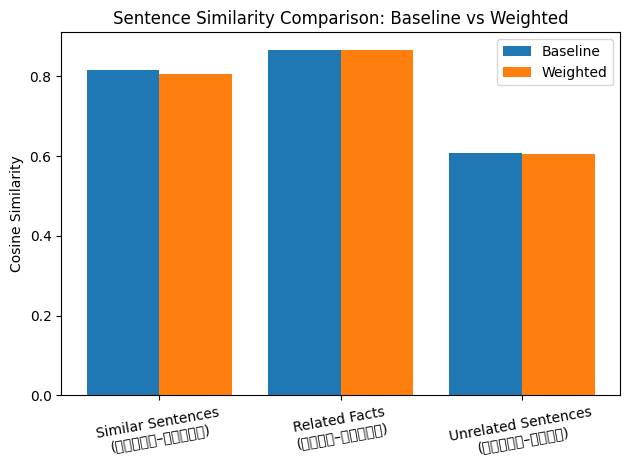

In [ ]:
import matplotlib.pyplot as plt

# Sentence similarity data
sentences = [
    "Similar Sentences\n(लड़की–लड़का)",
    "Related Facts\n(भारत–एशिया)",
    "Unrelated Sentences\n(लड़की–मौसम)"
]

baseline = [0.815, 0.867, 0.608]
weighted = [0.807, 0.865, 0.605]

x = range(len(sentences))

plt.figure()
plt.bar(x, baseline, width=0.4, label="Baseline", align='center')
plt.bar([i + 0.4 for i in x], weighted, width=0.4, label="Weighted", align='center')
plt.xticks([i + 0.2 for i in x], sentences, rotation=10)
plt.ylabel("Cosine Similarity")
plt.title("Sentence Similarity Comparison: Baseline vs Weighted")
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-688557444.py:23: UserWarning: Glyph 2354 (\N{DEVANAGARI LETTER LA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-688557444.py:23: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipython-input-688557444.py:23: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-688557444.py:23: UserWarning: Glyph 2364 (\N{DEVANAGARI SIGN NUKTA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-688557444.py:23: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-688557444.py:23: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-688557444.py:23: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipyt

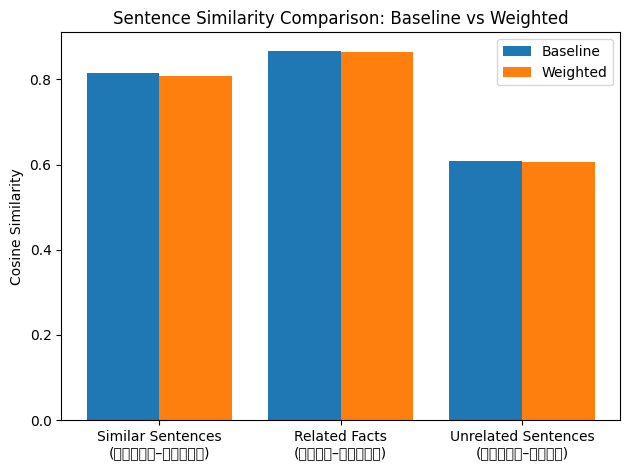

In [ ]:
import matplotlib.pyplot as plt

# Sentence similarity data
sentences = [
    "Similar Sentences\n(लड़की–लड़का)",
    "Related Facts\n(भारत–एशिया)",
    "Unrelated Sentences\n(लड़की–मौसम)"
]

baseline = [0.815, 0.867, 0.608]
weighted = [0.807, 0.865, 0.605]

x = list(range(len(sentences)))

plt.figure()
plt.bar(x, baseline, width=0.4, label="Baseline")
plt.bar([i + 0.4 for i in x], weighted, width=0.4, label="Weighted")
plt.xticks([i + 0.2 for i in x], sentences)
plt.ylabel("Cosine Similarity")
plt.title("Sentence Similarity Comparison: Baseline vs Weighted")
plt.legend()

plt.tight_layout()
plt.show()
